###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2019 Lorena A. Barba, Tingyu Wang

# Stick to the essentials: SVD

Welcome to the fourth lesson of the module "Land on Vector Spaces," on practical linear algebra with Python. The previous lesson focused on the _eigendecomposition_ of a matrix, and applications of eigenvalues and eigenvectors. 
In this lesson, we learn a new matrix decomposition that is useful in countless and important applications: **singular-value decomposition, SVD**.
In data science, for example, SVD is useful to remove redundant features in the data, while keeping the essential ones. 
SVD leads to methods for obtaining a least squares solution to an overdetermined linear system of equations. 
It can be used for the compression of images (as we illustrate below), and also for noise reduction. 
It's just an amazingly versatile, powerful idea!

Let's get ready to work, first loading our needed libraries.

In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot
pyplot.rc('font', family='serif', size=5)

In [2]:
import sys
sys.path.append('../scripts/')

# Our helper
from plot_helper import *

## Geometry of singular-value decomposition

In our previous lesson, we developed geometric intuition about eigenvectors, starting with a symmetric matrix, then looking at the general case. 
We also learned to use  [`numpy.linalg.eig()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) to obtain the eigenvalues and eigenvectors of an input array representing a matrix.

### Symmetric square matrix

Let's review the case of a symmetric matrix, using the `numpy.linalg.eig()` function with the matrix:

$$ A = \begin{bmatrix} 1 & 2 \\ 2 & 1 \end{bmatrix}$$

In [3]:
A = numpy.array([[1,2], [2,1]])
d, C = numpy.linalg.eig(A)

for eigenvalue, eigenvector in zip(d, C.T):
    print(eigenvalue, eigenvector)

3.0000000000000004 [0.70710678 0.70710678]
-0.9999999999999996 [-0.70710678  0.70710678]


The output of `numpy.linalg.eig(A)` is a 1D array with the eigenvalues of `A`, and a 2D array with the normalized eigenvectors as columns—here saved to the Python variables `d` and `C`, respectively. 
As we learned in the previous lesson, we can decompose the matrix as $\,A = C\, D\, C^{-1}$, where $D$ is the diagonal matrix of eigenvalues. 

Now use our custom function `plot_linear_transformation()` to plot both eigenvectors along with the linear transformation. 
The function allows the settings `unit_circle=True` to show the unit circle and `unit_vector=False` to hide the unit vectors. Have a look at the result.

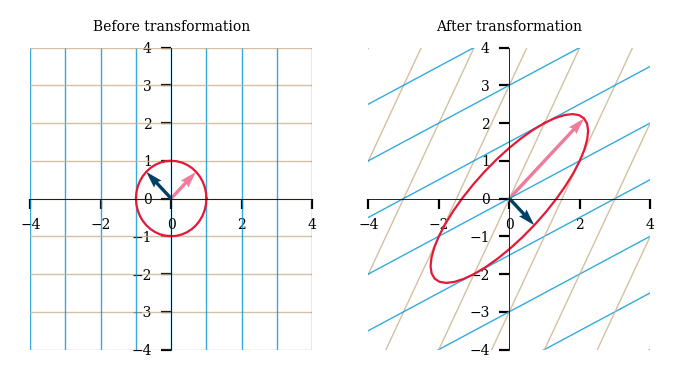

In [4]:
plot_linear_transformation(A, C[:,0], C[:,1], unit_vector=False, unit_circle=True)

Like we've seen before, the eigenvectors of $A$ (in pink and dark blue) don't change direction after the transformation. They also land on the semi-axes of the ellipse corresponding to the transformed unit circle. 
But this is only because $A$ is symmetric!

### Non-symmetric square matrix

If we try with a non-symmetric matrix, the eigenvectors still land on theis span, but this is no longer on the semi-axes of the ellipse. 
You can show it by plotting the eigenvectors before and after the transformation. 
Try with the new matrix:
$$\,A = \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}$$

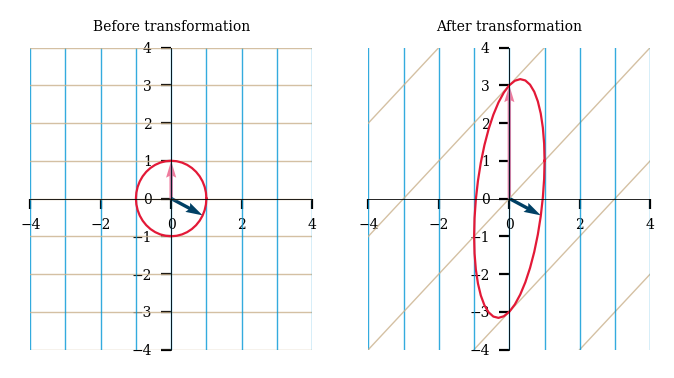

In [5]:
A = numpy.array([[1,0], [1,3]])
d, C = numpy.linalg.eig(A)
plot_linear_transformation(A, C[:,0], C[:,1], unit_vector=False, unit_circle=True)

How could we find the vectors that correspond to the semi-axes of the ellipse? They are intriguing because they are the most stretched or most shrunk vectors after the transformation. Similar to what we've done before, we calculate the maximum and minimum vector lengths after the transformation—the longest vector is on a semi-major axis, the shortest one is a on semi-minor axis.

In [6]:
alpha = numpy.linspace(0, 2*numpy.pi, 201)
circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
ellipse = A @ circle    # 2 by 41 ndarray

distance = numpy.linalg.norm(ellipse, axis=0)
major_id = numpy.argmax(distance)
minor_id = numpy.argmin(distance)
major = ellipse[:, major_id]
minor = ellipse[:, minor_id]
print(major, numpy.linalg.norm(major))
print(minor, numpy.linalg.norm(minor))

[0.33873792 3.16138023] 3.1794761076254896
[-0.94088077  0.07533299] 0.943891774007311


Recall that `major` and `minor` are transformed vectors that had a unit length before the transformation. To use our plotting function `plot_linear_transformation()` to visualize them, we need to pass in the corresponding vectors *before* the transformation. Let's name them `major_before` and `minor_before`, and find them using the inverse of $A$.

In [7]:
A_inv = numpy.linalg.inv(A)
major_before = A_inv @ major
minor_before = A_inv @ minor

We can finally plot the semi-axes now. Notice that we do not need to plot eigenvectors this time.

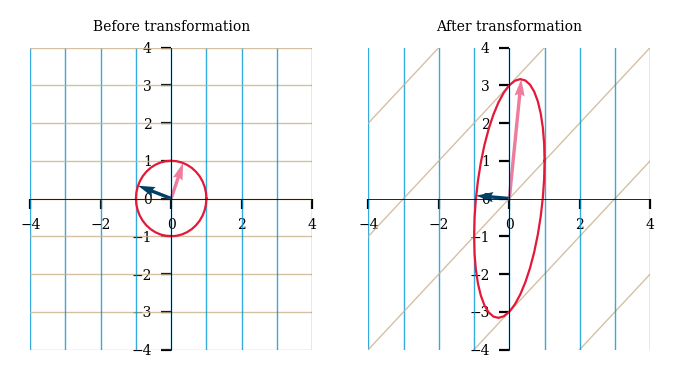

In [8]:
plot_linear_transformation(A, major_before, minor_before,
                           unit_vector=False, unit_circle=True)

We all know that the major and minor axes of an ellipse are orthogonal to each other—to our surprise, their corresponding vectors `major_before` and `minor_before`, on the original unit circle, appear to be orthogonal as well.

### Build the decomposition

If we use $\mathbf{u}_1, \mathbf{u}_2$ to denote the *normalized* `major` and `minor` vectors, use $\,\mathbf{s}_1, \mathbf{s}_2$ to denote the lengths of `major` and `minor`, and use $\mathbf{v}_1, \mathbf{v}_2$ to denote the vectors `major_before` and `minor_before` (they are normalized already since they are on the unit circle), we can formulate the above observation as:

$$
\begin{align*}
  A \mathbf{v}_1 = s_1 \mathbf{u}_1 \\
  A \mathbf{v}_2 = s_2 \mathbf{u}_2
\end{align*}
$$

Stacking the two equations together:

$$
  A \begin{bmatrix}
    \mathbf{v}_1 & \mathbf{v}_2
    \end{bmatrix}
    =
    \begin{bmatrix}
    \mathbf{u}_1 & \mathbf{u}_2
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 \\
    0 & s_2
    \end{bmatrix}  
$$

Using $V$ to denote $\begin{bmatrix} \mathbf{v}_1 & \mathbf{v}_2 \end{bmatrix}$, $U$ to denote $\begin{bmatrix} \mathbf{u}_1 & \mathbf{u}_2 \end{bmatrix}$ and $S$ to denote the diagonal scaling matrix, it becomes:

$$
  A\, V = U\, S
$$

Then right-multiply by $V^{-1}$ on both sides:

$$
  A = U\, S\, V^{-1}
$$

Since $\mathbf{v}_1, \mathbf{v}_2$ are orthogonal unit vectors, the matrix $V$ is an orthogonal matrix: $V^T = V^{-1}$ (as we saw in the previous lesson). The equation can also be re-written as:

$$
  A = U\, S\, V^{T}
$$

Starting from discovering the semi-axes of the transformed unit circle, we finally arrive at another neat decomposition of the matrix $A$: the **singular value decomposition** (SVD). The columns of $U$ are called left singular vectors, the columns of $V$ are called right singular vectors, and the diagonal elements of $S$ are called singular values.

Let's build these matrices to play with. We can use [`numpy.diag()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html) to create the diagonal matrix $S$: it takes a 1D array of diagonal values, and outputs a 2D array with these values on the diagonal and zero elsewhere.

In [9]:
s1 = numpy.linalg.norm(major)
s2 = numpy.linalg.norm(minor)
S = numpy.diag([s1, s2])
print(S)

[[3.17947611 0.        ]
 [0.         0.94389177]]


To build $U$, we need to first normalize the `major` and `minor` vectors, then stack them vertically using [`numpy.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html). Now each row represents a left singular vector, so we need to transpose the matrix to get the singular vectors as the columns of $U$.

In [10]:
u1 = major / s1
u2 = minor / s2
U = numpy.transpose(numpy.vstack((u1,u2)))
print(U)

[[ 0.10653891 -0.99681001]
 [ 0.99430853  0.07981105]]


Similarly, we can construct the matrix $V$ by stacking the right singular vectors. Computing the tranpose is not needed since we will use $V^T$ directly.

In [11]:
v1 = major_before
v2 = minor_before
VT = numpy.vstack((v1,v2))
print(VT)

[[ 0.33873792  0.94088077]
 [-0.94088077  0.33873792]]


We can now retrieve the matrix $A$ by multiplying them together!

In [12]:
U @ S @ VT

array([[1., 0.],
       [1., 3.]])

An orthogonal matrix ($U$ and $V$) implies a rotation transformation while a diagonal matrix ($S$) implies a scaling transformation. Let us visualize each matrix component in the SVD. This time, we also draw the unit vectors after each transformation.

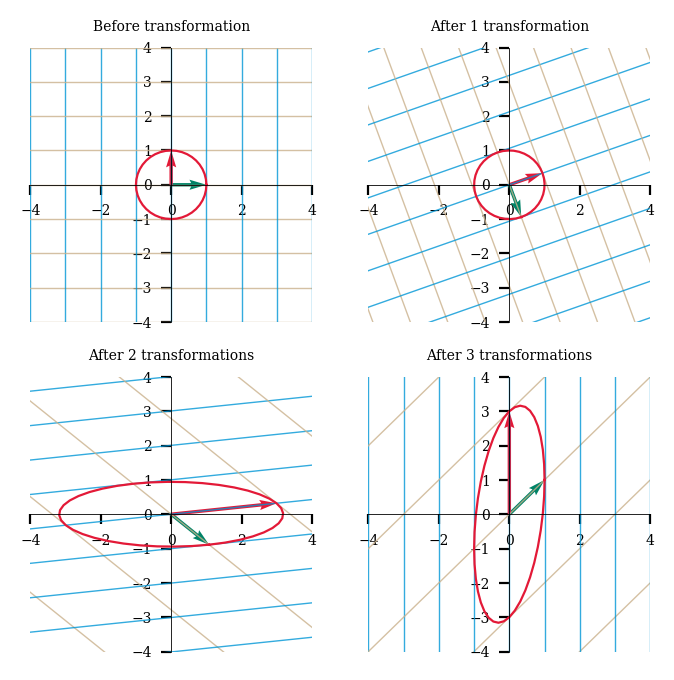

In [13]:
plot_linear_transformations(VT, S, U, unit_circle=True)

The matrix $V^T$ first "rotates" the unit circle, then the diagonal matrix $S$ "stretches" the unit circle in both the $x$-axis and $y$-axis directions into an ellipse, finally the matrix $U$ "rotates" this ellipse to a new direction. Therefore, the linear transformation by matrix $A$ can be viewed as a combination of rotation and scaling.

## Compute SVD in Python

You can compute the SVD of a matrix using [`numpy.linalg.svd()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html). It returns a tuple: the first element is a 2D array where each column is a left singular vector, the second element is a 1D array of the singular values, and the third element is a 2D array where each row is a right singular vector.

In [14]:
U, S, VT = numpy.linalg.svd(A)

Let us loop over each pair of singular values and singular vectors, and print them out. Note that to print the column vector of $U$, we need to use its transpose in the `for` statement.

In [15]:
for u, s, v in zip(U.T, S, VT):
    print(s, u, v)

3.1795868015587248 [0.10911677 0.99402894] [0.34694625 0.93788501]
0.9435188240589355 [ 0.99402894 -0.10911677] [ 0.93788501 -0.34694625]


We can use [`numpy.allclose()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) to confirm that the decomposition is very close to the matrix $A$.

In [16]:
A_svd = U @ numpy.diag(S) @ VT
print(A_svd)
print(numpy.allclose(A, A_svd))

[[ 1.00000000e+00 -3.88578059e-16]
 [ 1.00000000e+00  3.00000000e+00]]
True


## SVD in higher dimensions

We can also apply SVD to a 3D matrix using the NumPy built-in function `.svd()`. Our custom plotting function lets us visualize each component transformation. Although a little harder to make out, the linear transformation is still a composition of a rotation, a scaling and another rotation transformation.
Check it out.

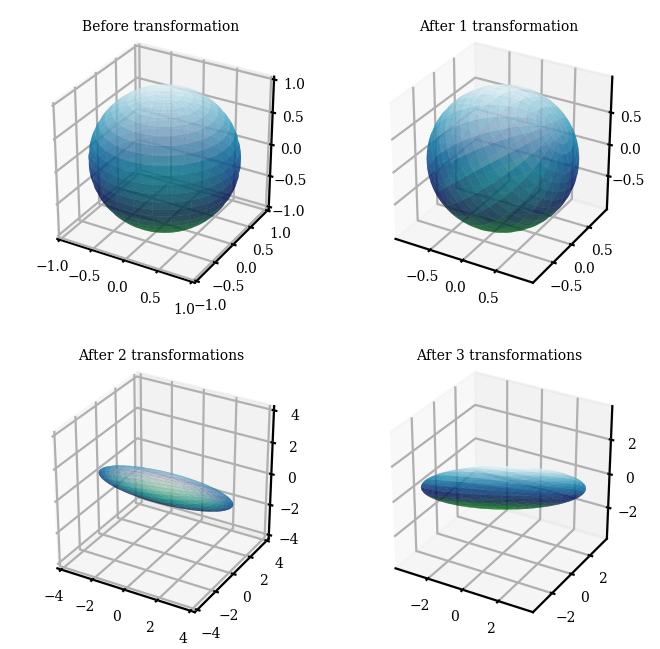

In [17]:
A = numpy.array([[1,2,3], [1,1,1], [-1,1,0]])
U, S, VT = numpy.linalg.svd(A)
plot_3d_linear_transformations(VT, numpy.diag(S), U, unit_sphere=True)

### Rank-deficient matrix

In our second lesson, we introduced the concept of *rank* of a matrix: the dimension of the vector space spanned by the matrix columns. In other words, rank corresponds to the number of linearly independent columns of a matrix. When the rank does not match the number of columns, the matrix is called *rank-deficient*.

Consider the rank-2 matrix $\;N = \begin{bmatrix} 1 & 2 & 7 \\
                                0 & 1 & 3 \\
                                -3 & 1 & 0 \end{bmatrix} $.
                                
Plotting this transformation below, you will find that the 3D grid lines collapse on a 2D plane: the transformation has the effect of reducing dimensionality of the space.

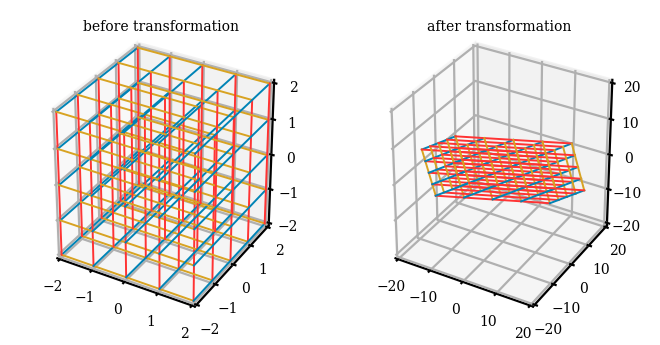

In [18]:
N = numpy.array([[1,2,7], [0,1,3], [-3,1,0]])
plot_3d_linear_transformation(N)

With the help of SVD, now we could look at this rank-deficient matrix from a different perspective. Let's plot each component of the SVD and turn on `unit_sphere` to visualize it.

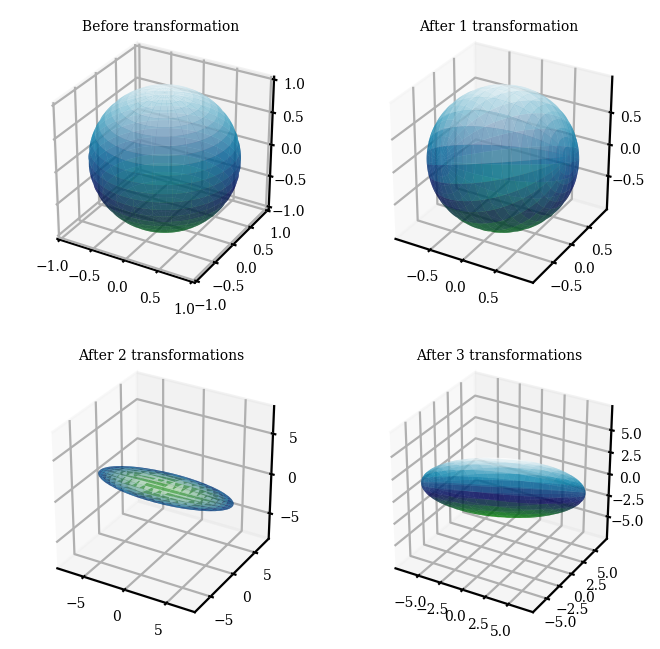

In [19]:
U, S, VT = numpy.linalg.svd(N)
plot_3d_linear_transformations(VT, numpy.diag(S), U, unit_sphere=True)

The second transformation squishes the unit sphere onto a flat ellipse on the plane $z=0$. Since each singular value describes the scaling ratio along the corresponding axis, what we observe implies that the third singular value, corresponding to the $z$-axis, is zero. Let's print out the singular values to verify.

In [20]:
print(S)

[7.98954415e+00 3.18860224e+00 2.66809284e-18]


For a $3 \times 3$ matrix, the number of nonzero singular values determines the dimensionality of the unit sphere after the transformation. If the matrix is full-rank, the transformed shape is an ellipsoid; if it has rank 2, the transformed shape is an ellipse; if it has rank 1, the transformed shape is a line segment. We can generalize this observation to higher dimensions as follows:

##### Key idea:

> The number of nonzero singular values of a square matrix $A$ is equal to its rank.

##### Challenge:

> Check the singular values of a rank-1 matrix.

For an $n \times n$ matrix, SVD can be written as (we use triple dots to indicate skipped rows or columns, and don't show the zero values of the scaling matrix):

$$
  A =
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_n}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & \\
    & s_2 & & \\
    & & \ddots \\
    & & & s_n
    \end{bmatrix}   
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_n}^T
    \end{bmatrix}
$$

When a matrix is rank-deficient with rank $k$, only the first $k$ singular values are non-zero; the decomposition can be truncated as follows:

$$
\begin{align*}
  A &=
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_k} & \dots & \mathbf{u_n}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & & \\
    & s_2 & & & \\
    & & \ddots & \\
    & & & s_k & \\
    & & & & \ddots \\
    & & & & & 0
    \end{bmatrix}    
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_k}^T \\
    \vdots \\
    \mathbf{v_n}^T
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2} & \dots & \mathbf{u_k}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & & & \\
    & s_2 & & \\
    & & \ddots \\
    & & & s_k
    \end{bmatrix}   
    \begin{bmatrix}
    \mathbf{v_1}^T \\
    \mathbf{v_2}^T \\
    \vdots \\
    \mathbf{v_k}^T
    \end{bmatrix}
\end{align*}
$$

We can drop the singular vectors from $U$ and $V$ whose corresponding singular values are zero. From a geometrical point of view, if a vector's component along an axis is squished to zero, it does not matter how you rotate that component to other axes.

In the example above, the $3 \times 3$ matrix $N$ has rank 2.

In [21]:
k = numpy.linalg.matrix_rank(N)
print(k)

2


We can reconstruct $N$ with only the first two singular vectors and singular values:

In [22]:
U, S, VT = numpy.linalg.svd(N)
N_k = U[:,:k] @ numpy.diag(S[:k]) @ VT[:k,:]
print(N_k)
print(numpy.allclose(N, N_k))

[[ 1.00000000e+00  2.00000000e+00  7.00000000e+00]
 [ 1.11022302e-16  1.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  1.00000000e+00 -8.74300632e-16]]
True


This implies a great advantage of low-rank matrices: they can be stored and reconstructed inexpensively by stripping zero singular values and the corresponding singular vectors from SVD.

### Low-rank approximation

Though low-rank matrices are easier to work with, the matrices from real-world applications often are not in our favor. 

Take a look at the $4 \times 4$ matrix
$ A = \begin{bmatrix} 1 & 2 & 3 & 6 \\
                      2 & 5 & 7 & 10 \\
                      3 & 9 & 12 & 14 \\
                      4 & 7 & 9 & 15 \end{bmatrix} $.
Let's first check the rank of $A$.

In [23]:
A = numpy.array([[1, 2, 3, 6],
                 [2, 5, 7, 10],
                 [3, 9, 12, 14],
                 [4, 7, 9, 15]])
print(numpy.linalg.matrix_rank(A))

4


It is difficult to visualize this linear transformation with a plot, but we can gain some insight by doing SVD. All four singular values are non-zero, but the last one is significantly smaller than the others and close to zero, indicating that the "4D unit sphere" is almost stamped onto a "plane" in that direction. In other words, $A$ has full rank but is very close to a rank-$3$ matrix.

In [24]:
U, S, VT = numpy.linalg.svd(A)
print(S)

[31.94504943  2.81273628  0.77396598  0.05751823]


Since the scaling factor along the last axis is negligible, why not try to approximate the matrix $A$ with the three largest singular values?

In [25]:
k = 3
A_k = U[:,:k] @ numpy.diag(S[:k]) @ VT[:k,:]
print(A_k)
print(numpy.linalg.matrix_rank(A_k))

[[ 1.01333778  1.9779498   3.0176867   5.99611842]
 [ 1.98096577  5.03146764  6.97475947 10.00553936]
 [ 3.00726293  8.98799282 12.00963108 13.99788633]
 [ 4.00058714  6.99902932  9.00077859 14.99982913]]
3


By dropping the smallest singular value and its singular vectors in the decomposition, we arrive at a rank-$3$ approximation of matrix $A$. Though `A_k` is rank-deficient, each entry is very close to the full-rank matrix `A`. The example might look trivial, but it demonstrates the important idea that we can sometimes approximate a higher-rank matrix with a reduced-rank matrix to save storage cost. This strategy is called *low-rank approximation*, and you will find that it's ubiquitous in scientifc computing.

## Application to image compression

Low-rank approximation is widely used in data compression to reduce storage cost. In this section, we will use SVD to compress a grayscale image of the Washington Monument and explore the tradeoff between compression ratio and image quality.

We will use the `imageio` library to manipulate image data. First, load the image file to an array using [`imageio.imread()`](https://imageio.readthedocs.io/en/stable/userapi.html#imageio.imread).

In [26]:
from imageio import imread
image = imread('../images/washington-monument.jpg')

The type of this array is a subclass of `numpy.ndarray`, so we treat it as a `numpy` array. Let's check its shape and data type.

In [27]:
print(type(image))
print(image.shape)
print(image.dtype)

<class 'imageio.core.util.Array'>
(300, 300)
uint8


The image was converted into a $300 \times 300$ array, and each entry is an integer value that indicates some gray intensity between 0 (black) and 255 (white). Given the image array, we can use `pyplot.imshow()` to display the image and set the colormap to gray.

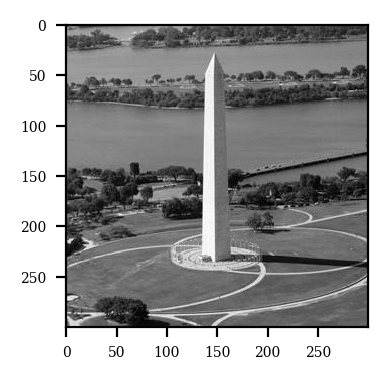

In [28]:
pyplot.figure(figsize=(2,2))
pyplot.imshow(image, cmap='gray');

Now we are ready to factorize this image with SVD.

In [29]:
U, S, VT = numpy.linalg.svd(image)
print(U.shape, S.shape, VT.shape)

(300, 300) (300,) (300, 300)


Let us visualize the distribution of its singular values, the indices of which are on the $x$-axis. Notice that the singular values are sorted in descending order.

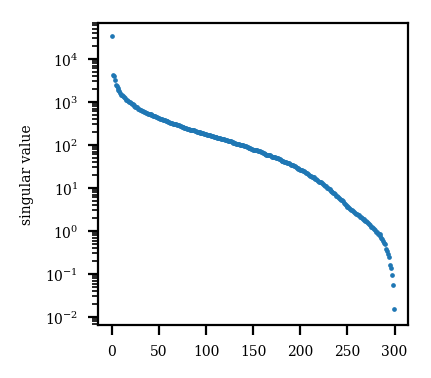

In [30]:
pyplot.figure(figsize=(2,2))
pyplot.scatter(numpy.arange(len(S)), S, s=0.5)
pyplot.yscale('log')
pyplot.ylabel('singular value');

Without compression, the square image requires the space to store $300^2$ integers. With a rank-$k$ approximation, we would only need to store the truncated SVD components: $300k$ integers for $U$, $k$ integers for $S$ and another $300k$ integers for $V^T$. The compression ratio can be defined as:

$$\text{compression ratio} = \frac{300^2}{300k+k+300k}$$

This ratio should be greater than 1, namely, the rank $k$ should be less than $149$, otherwise we deviate from the goal of compression.

To visualize how the compressed image changes with varying $k$, we use Jupyter widgets to generate the interactive visualization. Let's import the module and create an integer-type slider for the reduced rank $k$.

In [31]:
from ipywidgets import widgets, fixed
k_slider = widgets.IntSlider(min=1, max=149, step=5)
display(k_slider)

IntSlider(value=1, max=149, min=1, step=5)

The number displayed on the right automatically changes as you drag the slider. We can set a minimum and maximum value, as well as a step, to this rank slider.

To render the image dynamically, we need to use [`widgets.interact()`](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) which takes a plotting function as input. When we change $k$ by dragging the slider, this plotting function will be re-executed with the new value of $k$, therefore, the image will be updated.

Below is the plotting function `approximate()` to work with `widgets.interact()`. It takes a reduced rank $k$, an image array and its SVD components as arguments. The SVD components are explicitly passed in so that we only compute SVD once.

In [32]:
def approximate(k, u, s, vt, image):
    u_k = u[:,:k]
    s_k = s[:k]
    vt_k = vt[:k,:]
    copy = numpy.round(u_k @ numpy.diag(s_k) @ vt_k)
    diff = image - copy
    fig = pyplot.figure(figsize=(4,2))
    ax1 = pyplot.subplot(121)
    ax1.imshow(copy, cmap='gray')
    ax1.set_title('compressed image'.format(k))
    ax2 = pyplot.subplot(122)
    ax2.imshow(image, cmap='gray')
    ax2.set_title('original image'.format(k))
    
    ratio = image.size / (u_k.size + s_k.size + vt_k.size)
    norm = numpy.linalg.norm(diff)
    pyplot.subplots_adjust(top=0.85)
    fig.suptitle('$k = {}$, compression ratio = {:.2f}, norm = {:.2f}'
                 .format(k, ratio, norm), fontsize=5)

To quantify the quality of the compressed image, we calculate the Frobenius norm of the difference matrix between the original image and the compress image using `numpy.linalg.norm()`. A smaller norm indicates a better compression quality.

Finally, we call the `.interact()` function and pass in the plotting function and our slider. Try changing $k$ to see how it affects the image quality, the Frobenius norm of the difference matrix and the compression ratio.

In [33]:
widgets.interact(approximate, k=k_slider, u=fixed(U),
                 s=fixed(S), vt=fixed(VT), image=fixed(image));

interactive(children=(IntSlider(value=1, description='k', max=149, min=1, step=5), Output()), _dom_classes=('w…

## Nonsquare matrices

So far, we have only talked about square matrices. A $2\times 2$ matrix transforms a 2D vector to another 2D vector, and a $3\times 3$ matrix transforms a 3D vector to another 3D vector. What about the nonsquare ones, for example, a $3 \times 2$ matrix $A =  \begin{bmatrix} 1 & 0 \\ 1 & 1 \\ 2 & 3\end{bmatrix}$ ?

In the first lesson, we discussed that the matrix-vector multiplication $A\mathbf{x}$ is a linear combination of the columns of $A$ scaled by the components of $\mathbf{x}$. Since $A$ has two columns, $\mathbf{x}$ should have two components. Each column of $A$ is a 3D vector, therefore, the linear combination of the columns $A\mathbf{x}$ should also be a 3D vector. Yes, this matrix $A$ transforms a 2D vector into a 3D vector.

If we use $\mathbf{i}$ and $\mathbf{j}$ to denote the standard basis vectors. The first column corresponds to the vector where $\mathbf{i}$ lands after the transformation, and the second column is where $\mathbf{j}$ lands:
$$
\mathbf{i} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}  \Rightarrow  \begin{bmatrix} 1 \\ 1 \\ 2 \end{bmatrix} \\
\mathbf{j} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}  \Rightarrow  \begin{bmatrix} 0 \\ 1 \\ 3 \end{bmatrix}
$$

so a vector $\mathbf{x} = \begin{bmatrix} x \\ y \end{bmatrix}$ will land in $ A\mathbf{x} = x \cdot \begin{bmatrix} 1 \\ 1 \\ 2 \end{bmatrix} + y \cdot \begin{bmatrix} 0 \\ 1 \\ 3 \end{bmatrix}$.

##### Key idea:

> An $m\times n$ nonsquare matrix transforms an $n$-dimensional vector to an $m$-dimensional vector.

Matrix-matrix multiplication represents the composition of two linear transformations. For nonsquare matrices, we need to make sure that the dimension of the transformed vector of the previous transformation matches the dimension of the input vector of the next transformation. If matrix $A$ is $m\times n$, matrix $B$ is $n\times p$, the matrix product $AB$ is $m \times p$.

### SVD in general

In fact, SVD also exists for nonsquare matrices. An $m \times n$ matrix $M$ can be factorized as:

$$
\underset{m\times n}M = \underset{m\times m}U\,\, \underset{m\times n}S\,\,
\underset{n\times n}{V^T}
$$

$U$ and $V$ are orthogonal matrices, and they can be treated as rotation transformations. $S$ is an $m \times n$ rectangular diagonal matrix and still represents a scaling transformation, but in contrast to square matrices, $S$ now transforms an $n$-dimensional vector to an $m$-dimensional vector.

We can use the same built in function `numpy.linalg.svd()` to decompose rectangular matrices. Take the following $3\times 4$ matrix as an example:

In [34]:
M = numpy.array([[1, 3, 4, 4],
                 [2, 5, 7, 10],
                 [3, 4, -1, 0]], dtype=float)
u, s, vt = numpy.linalg.svd(M)

Let's check the shape of each component.

In [35]:
print(u.shape, s.shape, vt.shape)

(3, 3) (3,) (4, 4)


The second return value `s` is a vector, it only keeps the diagonal elements of $S$. In the example above, we used `numpy.diag(s)` to construct $S$ for a square matrix. The same code won't work here because $S$ has to be a $3\times 4$ matrix in this case, while `numpy.diag(s)` only creates a $3 \times 3$ matrix. If you tried to use
```Python
u @ numpy.diag(s) @ vt
```
to reconstruct $M$, you would get the error message:
```
ValueError: shapes (3,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)
```
To fix it, first we need to create $S$ with the correct shape using `numpy.zeros_like()`, then fill the diagonal with the singular values.

In [36]:
S = numpy.zeros_like(M, dtype=float)
S[:len(s), :len(s)] = numpy.diag(s)

We can now reconstruct the rectangular matrix $M$ using the three components.

In [37]:
u @ S @ vt

array([[ 1.,  3.,  4.,  4.],
       [ 2.,  5.,  7., 10.],
       [ 3.,  4., -1.,  0.]])

### Pseudo-inverse

From the previous notebook, we treat a matrix's inverse as the reverse linear transformation that brings the transformed vectors back to their original coordinates. So far, we have only considered square matrices, and only the ones with full rank have an inverse. What about the inverse of a rectangular matrix? Have a try using the built-in function `numpy.linalg.inv()`.


The inverse of a nonsquare matrix does not exist. You can think of a nonsquare matrix as the coefficient matrix of a linear system of equations. Since the number of equations is not equal to the number of unknowns, there is no unique solution to the system, thus we cannot find the inverse of a nonsquare matrix.

Despite lack of an inverse, nonsquare matrices do have a generalized form of inverse, called *pseudo-inverse*. It satisfies weaker conditions than the standard inverse and exists for all rectangular matrices. The idea of this generalized inverse is closed related to SVD. Given the SVD of an $m \times n$ matrix $M = U \, S\, V^T$, the pseudo-inverse $M^\dagger$ is defined as:

$$
\underset{n\times m}M^\dagger = \underset{n\times n}V \,\, \underset{n\times m}{S^\dagger} \,\, \underset{m\times m}{U^T}
$$

where $S^\dagger$ comes from $S$ by taking the reciprocal of the nonzero diagonal elements of $S$, all other elements in $S^\dagger$ are zero. If the diagonal elements of $S$ are $(s_1, s_2, \dots, s_r, 0, \dots, 0)$, the diagonal elements of $S^\dagger$ are $(\frac{1}{s_1}, \frac{1}{s_2}, \dots, \frac{1}{s_r}, 0, \dots, 0)$, where $r$ denotes the number of nonzero singular values.

When multiplying $M$ by $M^\dagger$, we get:

$$
\begin{align*}
M M^\dagger &= U S V^T V S^\dagger U^T
\end{align*}
$$

Recall that $U$ and $V$ are orthogonal matrices, therefore, $UU^T = I$ and $VV^T = I$. In addition, the nonzero diagonal elements of $S$ are the reciprocals of the diagonal of $S^\dagger$. The product $MM^\dagger$ is as close as we can get to identity matrix $I$, hence $M^\dagger$ is the generalized inverse of $M$. 

NumPy offers the built in function [`numpy.linalg.pinv()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html) to calculate the pseudo-inverse of a given matrix.

In [38]:
M_inv = numpy.linalg.pinv(M)
print(M_inv)

[[-1.42643764e-01  6.57206871e-02  1.27707244e-01]
 [ 2.65870052e-01 -1.12023898e-01  1.23226288e-01]
 [ 6.35548917e-01 -2.50933532e-01 -1.23973114e-01]
 [-5.49290515e-01  3.18521285e-01 -3.73412995e-04]]


##### Challenge:

> Use the SVD components to construct the pseudo-inverse of a nonsquare matrix, and compare it with the result from using the built in function `numpy.linalg.pinv()`.

### Application to linear least squares

A popular application of psuedo-inverse is solving linear *least square* problems. The *least square* method offers a way to "solve" an *overdetermined* linear system of equations, where there are more equation than unknowns in the system. The following linear system is overdetermined:

$$
\begin{align*}
2x + y &= -1 \\
3x - y &= 2  \\
x - y  &= -1
\end{align*}
$$

Drawing the lines on the same plot below, you will find that there is no exact solution that can satisfy all three equations.

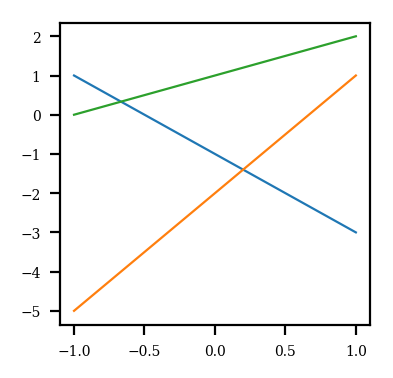

In [39]:
x = numpy.array([-1, 1])
pyplot.figure(figsize=(2,2))
pyplot.plot(x, -1-2*x, lw=0.8)
pyplot.plot(x, 3*x-2, lw=0.8)
pyplot.plot(x, x+1, lw=0.8);

But can we find a pair of $x$ and $y$ that will make the left hand side (LHS) and the right hand side (RHS) as close as possible? In other words, can we come up with an approximate solution to this linear system?

In the study of the shape of the earth and celestial orbits, Gauss and Legendre answered this question by proposing the *least squares* approach which minimizes the sum of the square of the residuals, the difference between LHS and RHS, of each equation.

In our case, the least squares method is to find $x$ and $y$ that minimizes the sum $S(x,y) = (2x + y + 1)^2  + (3x - y - 2)^2 + (x - y + 1)^2$. You might have learnt in your calculus class that you can set partial derivatives to zero to find this saddle point, but today we would like to solve using a neat feature of pseudo-inverse. For an overdetermined linear system $A\mathbf{x} = \mathbf{b}$, the least squares solution is given by:

$$
\mathbf{x} = A^\dagger \, \mathbf{b} = V S^\dagger U^T \, \mathbf{b}
$$

where $A^\dagger$ is the pseudo-inverse of the coefficient matrix $A$.

With pseudo-inverse built in function, we can obtain the least squares solution to the linear system above.

In [40]:
A = numpy.array([[2, 1],
                 [3, -1],
                 [1, -1]])
b = numpy.array([-1, 2, -1])
A_inv = numpy.linalg.pinv(A)
x_ls = A_inv @ b
print(x_ls)

[ 0.13157895 -0.57894737]


This pair of $x$ and $y$ minimizes the sum of the squared residuals.

##### Optional

If you still prefer to solve this linear least squares problem in a "calculus" way, below is how we compute the solution in a symbolic manner using `sympy` functions.

In [41]:
import sympy
sympy.init_printing(use_latex = 'mathjax') #configures the display of mathematics

First, define symbol `x`, `y` and the sum as an expression of $x$ and $y$.

In [42]:
x, y = sympy.symbols('x y')
sum_ls = (2*x+y+1)**2 + (3*x-y-2)**2 + (x-y+1)**2
sum_ls

           2                2                2
(x - y + 1)  + (2⋅x + y + 1)  + (3⋅x - y - 2) 

Then, use `sympy.diff()` to calculate the symbolic partial derivatives.

In [43]:
dsdx = sympy.diff(sum_ls, x)
dsdy = sympy.diff(sum_ls, y)

Finally, we use `sympy.solve()` to solve the linear system generated from equating the derivates to zero. The solution matches the one from using pseudo-inverse.

In [44]:
sympy.solve((dsdx, dsdy), x, y)

⎧            -11 ⎫
⎨x: 5/38, y: ────⎬
⎩             19 ⎭

### Linear regression with SVD

Least squares method is often used for data fitting. Given a set of data, we aim to find the best-fitting curve by minimizing the sum of the squared residuals of the data points from the curve. In this section, we grab the land temperature anomaly data over years from the NOAA (National Oceanic and Atmospheric Administration) website, and our task is to fit the trend with a straight line using SVD.

In [45]:
from urllib.request import urlretrieve
URL = 'http://go.gwu.edu/engcomp1data5?accessType=DOWNLOAD'
fname = 'land_global_temperature_anomaly-1880-2016.csv'
urlretrieve(URL, fname)

('land_global_temperature_anomaly-1880-2016.csv',
 <http.client.HTTPMessage at 0x120d94a90>)

To start, we use the function `numpy.loadtxt()` to load the data to NumPy arrays. Here, we'll save the data into the arrays `year` and `temp_anomaly`. 

In [46]:
year, temp_anomaly = numpy.loadtxt(fname, delimiter=',', skiprows=5, unpack=True)
print(year.shape, temp_anomaly.shape)

(137,) (137,)


Let us take a look at the trend.

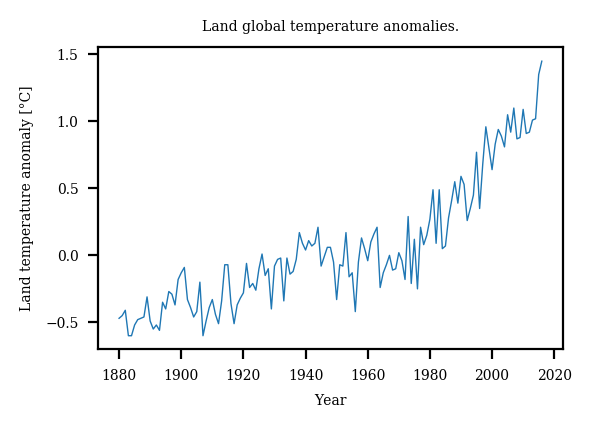

In [47]:
#You can set the size of the figure by doing:
pyplot.figure(figsize=(3,2))

#Plotting
pyplot.plot(year, temp_anomaly, linestyle='-', linewidth=0.5) 
pyplot.title('Land global temperature anomalies.')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]');

There are 137 temperature anomaly data points which span from year 1880 to year 2016. Our task is to model the trend with a straight line: $t = b + k y$, where $t$ represents the temperature anomaly, $y$ denotes the year, $b$ and $k$ are the intercept and the slope of the fitted line respectively.

The linear system consisting of 137 data points looks like:

$$
\begin{align*}
b + k y_1 &= t_1 \\
b + k y_2 &= t_2 \\
  \vdots \\
b + k y_{137} &= t_{137}
\end{align*}
$$

This is an overdetermined system with 137 equations and 2 unknowns ($k$ and $b$). Let us define

$$
A = \begin{bmatrix} 1 & y_1 \\
                    1 & y_2 \\
                    \vdots & \vdots \\
                    1 & y_{137} \end{bmatrix}                    
$$

$$\mathbf{x} = \begin{bmatrix} b \\ k \end{bmatrix}$$

$$
\mathbf{t} = \begin{bmatrix} t_1 \\
                      t_2 \\
                      \vdots \\
                      t_{137} \end{bmatrix} 
$$

Let's build matrix $A$.

In [48]:
A = numpy.zeros((137,2))
A[:,0] = 1
A[:,1] = year

The matrix form of this overdetermined system is $A \mathbf{x} = \mathbf{t}$. Therefore, the least squares solution is given by $\mathbf{x} = A^\dagger \mathbf{t}$.

In [49]:
A_inv = numpy.linalg.pinv(A)
x_ls = A_inv @ temp_anomaly
b, k = x_ls

Finally, we can plot the linear fit of the temperature anomalies together with the orginal data.

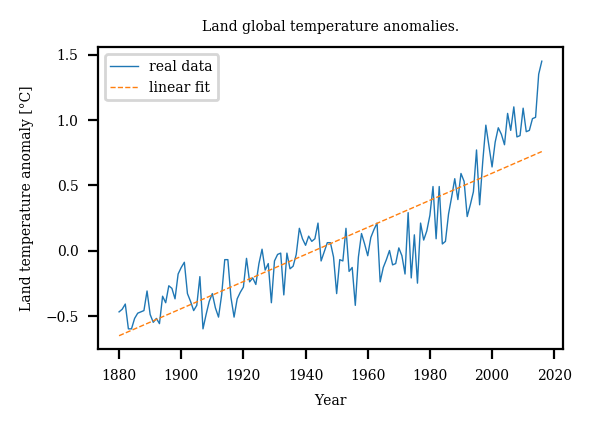

In [50]:
pyplot.figure(figsize=(3,2))
pyplot.plot(year, temp_anomaly, linestyle='-', linewidth=0.5, label='real data')
pyplot.plot(year, b + k*year, linestyle='--', linewidth=0.5, label='linear fit')
pyplot.title('Land global temperature anomalies.')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.legend();

In [51]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())